In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_classif, SelectKBest

from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict,cross_val_score,cross_validate
from sklearn.model_selection import GridSearchCV

In [198]:
df = pd.read_csv('AB_NYC_2019.csv',delimiter = ',')

# **Exploratory Data Analysis & Feature Creation**

 **dealing with missing value and outlier**

In [199]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [201]:
# check missing values
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [202]:
# Check if all rows with NaN value in 'last_review' contains value 0 in 'number_of_reviews'
matching_rows_df = df[(df['number_of_reviews'] == 0) & (df['last_review'].isnull())]
if len(matching_rows_df) == df['last_review'].isnull().sum():
    print("All NaN rows in 'last_review' have the corresponding value 0 in the 'number_of_reviews'")
else:
    print("There are NaN rows without the corresponding value in the 'number_of_reviews'")

All NaN rows in 'last_review' have the corresponding value 0 in the 'number_of_reviews'


count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


/var/folders/jn/gt3868vd039by14gxmgb54b40000gn/T/ipykernel_51235/1827350110.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'])


<AxesSubplot: xlabel='price', ylabel='Density'>

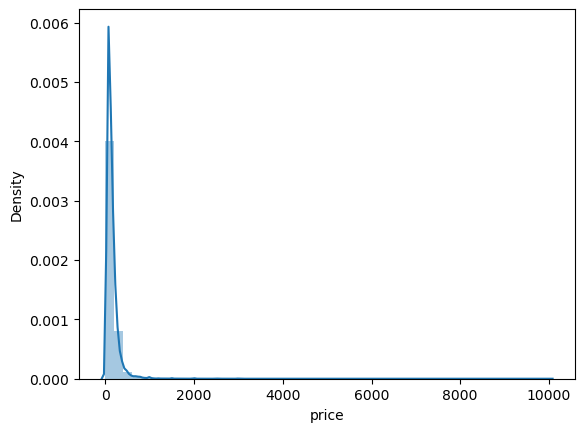

In [203]:
print(df['price'].describe())
sns.distplot(df['price'])

In [204]:
# drop the rows with price equaling to 0
df1 = df[df['price'] != 0]
df1.reset_index(drop=True, inplace=True)


#drop the rows with price higher than the 95% quantile to reduce the impact of outliers.
print(df['price'].quantile(0.95))
print((df1['price'] >= df['price'].quantile(0.95)).sum())
df1 = df1[df1['price'] <= df['price'].quantile(0.95)]
df1.reset_index(drop=True, inplace=True)

df1.info()

355.0
2451
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46443 entries, 0 to 46442
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              46443 non-null  int64  
 1   name                            46428 non-null  object 
 2   host_id                         46443 non-null  int64  
 3   host_name                       46422 non-null  object 
 4   neighbourhood_group             46443 non-null  object 
 5   neighbourhood                   46443 non-null  object 
 6   latitude                        46443 non-null  float64
 7   longitude                       46443 non-null  float64
 8   room_type                       46443 non-null  object 
 9   price                           46443 non-null  int64  
 10  minimum_nights                  46443 non-null  int64  
 11  number_of_reviews               46443 non-null  int64  
 12  last_review          

In [205]:
# to assignment values to missing ones.
df1['last_review'] = df1['last_review'].fillna('2020-01-01')
df1['reviews_per_month'] = df1['reviews_per_month'].fillna(0)
df1.isna().sum()

id                                 0
name                              15
host_id                            0
host_name                         21
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
last_review                        0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
dtype: int64

In [206]:
df1.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.644300e+04,4.644300e+04,46443.000000,46443.000000,46443.000000,46443.000000,46443.000000,46443.000000,46443.000000,46443.000000
mean,1.891941e+07,6.646223e+07,40.728576,-73.950978,122.612794,6.944297,23.823009,1.104909,6.686627,109.706264
std,1.093144e+07,7.769824e+07,0.055187,0.046383,71.971323,19.875539,45.184378,1.610275,31.131876,130.423905
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.445547e+06,7.719674e+06,40.689360,-73.982100,65.000000,1.000000,1.000000,0.050000,1.000000,0.000000
50%,1.954585e+07,3.034546e+07,40.722020,-73.954580,100.000000,2.000000,5.000000,0.380000,1.000000,40.000000
75%,2.893970e+07,1.056556e+08,40.763330,-73.934630,160.000000,5.000000,24.000000,1.610000,2.000000,218.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,355.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [207]:
# split data into Numerical data & Categorical data
def split_num_cat(data):
    num_data = data.select_dtypes(exclude=['object'])
    cat_data = data.select_dtypes(include=['object'])
    return num_data, cat_data

num, cat = split_num_cat(df1)
print(num.columns)
print(cat.columns)

Index(['id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')
Index(['name', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'room_type', 'last_review'],
      dtype='object')


 **numerical variables**

/var/folders/jn/gt3868vd039by14gxmgb54b40000gn/T/ipykernel_51235/265618623.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1[col], ax=axes[i])
/var/folders/jn/gt3868vd039by14gxmgb54b40000gn/T/ipykernel_51235/265618623.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1[col], ax=axes[i]

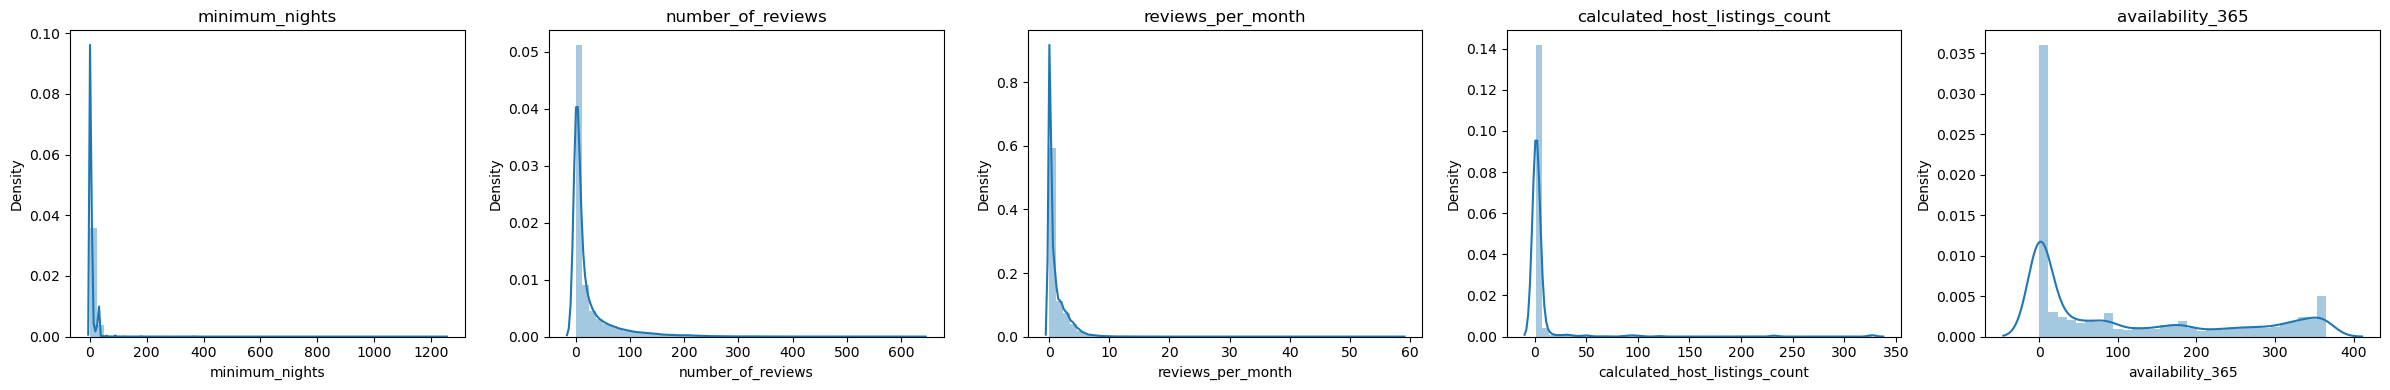

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,46443.000000,46443.000000,46443.000000,46443.000000,46443.000000
mean,6.944297,23.823009,1.104909,6.686627,109.706264
std,19.875539,45.184378,1.610275,31.131876,130.423905
min,1.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,1.000000,0.050000,1.000000,0.000000
50%,2.000000,5.000000,0.380000,1.000000,40.000000
75%,5.000000,24.000000,1.610000,2.000000,218.000000
max,1250.000000,629.000000,58.500000,327.000000,365.000000


In [208]:
# check the distribution of each numerical feature
cols = ['minimum_nights', 'number_of_reviews', 'reviews_per_month','calculated_host_listings_count','availability_365']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(24, 4))
for i, col in enumerate(cols):
    sns.distplot(df1[col], ax=axes[i])
    axes[i].set_title(col)
# Show the plot
plt.tight_layout()
plt.show()

df1[cols].describe()

In [209]:
print(df1['calculated_host_listings_count'].quantile(0.95))
print((df1['calculated_host_listings_count']>df1['calculated_host_listings_count'].quantile(0.95)).sum())
print(df1['reviews_per_month'].quantile(0.95))
print((df1['reviews_per_month']>df1['reviews_per_month'].quantile(0.95)).sum())

13.0
2315
4.35
2315


In [210]:
# add two columns to reduce the impact of outliers in 'calculated_host_listings_count' & 'reviews_per_month'
df1['adj_calculated_host_listings_count'] = np.where(df1['calculated_host_listings_count'] > df1['calculated_host_listings_count'].quantile(0.95),\
                                        df1['calculated_host_listings_count'].quantile(0.95), df1['calculated_host_listings_count'])
df1['adj_reviews_per_month'] = np.where(df1['reviews_per_month'] > df1['reviews_per_month'].quantile(0.95),\
                                        df1['reviews_per_month'].quantile(0.95), df1['reviews_per_month'])


In [211]:
df1.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,adj_calculated_host_listings_count,adj_reviews_per_month
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,6.0,0.21
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,2.0,0.38
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,2020-01-01,0.00,1,365,1.0,0.00
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,1.0,4.35
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,1.0,0.10


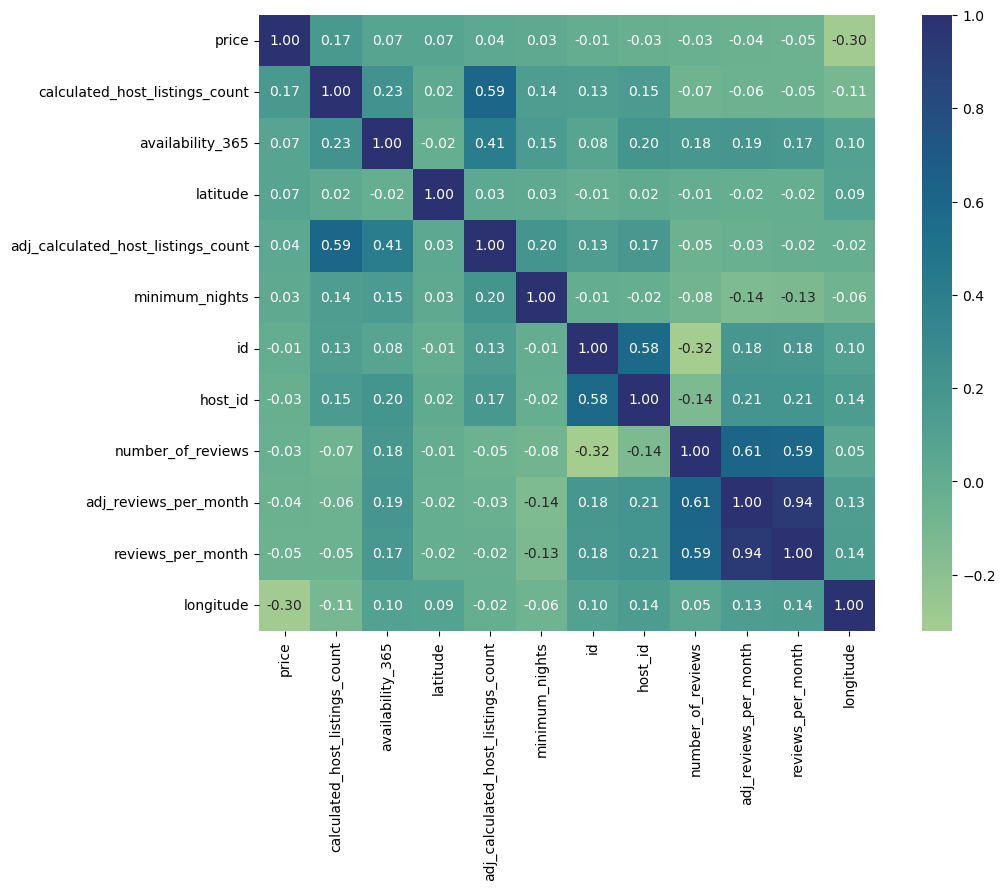

In [212]:
# create the correlation heatmap

# checking for top variables in term of correlation with price
corr=df1.corr()
k = 15 #number of variables for heatmap
cols = corr.nlargest(k, 'price')['price'].index
corr_10=corr.loc[cols,cols]
plt.figure(figsize=(12,8))
sns.heatmap(corr_10,annot=True,square=True,fmt='.2f', annot_kws={'size': 10},yticklabels=cols.values, xticklabels=cols.values,cmap='crest')
plt.show()

 **categorical variables**

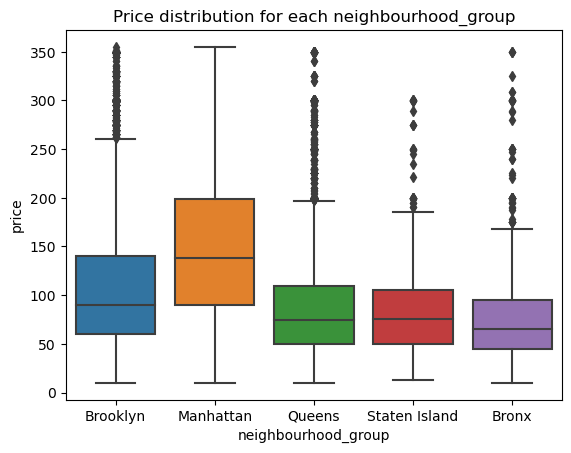

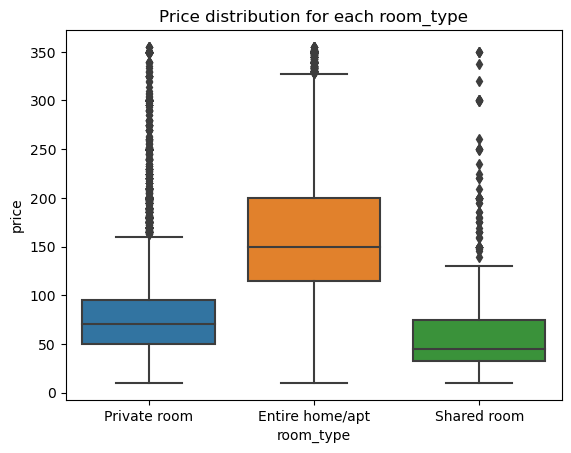

In [213]:
# check the correlation between price and every categorical feature.

# price by neighbourhood_group
ax = sns.boxplot(data=df1, x='neighbourhood_group', y='price')
ax.set_title('Price distribution for each neighbourhood_group')
plt.show()

# price by room_type
ax = sns.boxplot(data=df1, x='room_type', y='price')
ax.set_title('Price distribution for each room_type')
plt.show()


2020     9186
2019    24108
2018     5825
2017     3118
2016     2603
2015     1337
2014      189
2013       46
2012       24
2011        7
Freq: A-DEC, Name: y_last_review, dtype: int64


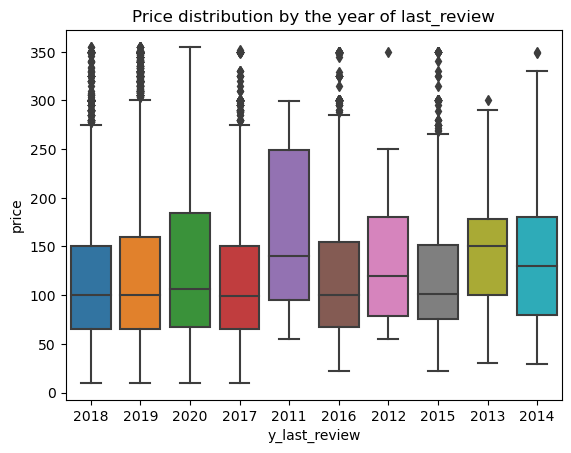

In [214]:
# add two columns containing information about last_review in a yearly or yearly+monthly basis.
# I'm not sure how much does it work.

df1['y_m_last_review'] = pd.to_datetime(df1['last_review']).dt.to_period('M')
df1['y_last_review'] = pd.to_datetime(df1['last_review']).dt.to_period('Y')
print(df1['y_last_review'].value_counts().sort_index(ascending=False))

# price by y_last_review
ax = sns.boxplot(data=df1, x='y_last_review', y='price')
ax.set_title('Price distribution by the year of last_review')
plt.show()


In [215]:
# add a column combining the inforamtion of neighbourhood with neighbourhood_group
df1['adj_neighbourhood'] = df1['neighbourhood_group'].str.cat(df1['neighbourhood'], sep=' ')
df1.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,adj_calculated_host_listings_count,adj_reviews_per_month,y_m_last_review,y_last_review,adj_neighbourhood
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,9,2018-10-19,0.21,6,365,6.0,0.21,2018-10,2018,Brooklyn Kensington
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,45,2019-05-21,0.38,2,355,2.0,0.38,2019-05,2019,Manhattan Midtown
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,0,2020-01-01,0.00,1,365,1.0,0.00,2020-01,2020,Manhattan Harlem
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,270,2019-07-05,4.64,1,194,1.0,4.35,2019-07,2019,Brooklyn Clinton Hill
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,9,2018-11-19,0.10,1,0,1.0,0.10,2018-11,2018,Manhattan East Harlem


In [216]:
# using ANOVA to check the correlation of categorical features and our predictive variable(price)

model = sm.OLS.from_formula('price ~ C(adj_neighbourhood)', data=df1).fit()
sm.stats.anova_lm(model, typ=2)

# we can see that adj_neighbourhood is an important categorical feature to some extent cuz the F-value is 8.3 with 0 p-value.

,sum_sq,df,F,PR(>F)
C(adj_neighbourhood),5.976575e+07,218.0,70.092277,0.0
Residual,1.807978e+08,46224.0,NaN,NaN


In [217]:
model2 = ols('price ~ neighbourhood_group', data=df1).fit()
sm.stats.anova_lm(model2, typ=2)

# we can see that neighbourhood_group is a very important categorical feature cuz the F-value is very large with 0 p-value.

,sum_sq,df,F,PR(>F)
neighbourhood_group,2.750037e+07,4.0,1498.454477,0.0
Residual,2.130632e+08,46438.0,NaN,NaN


In [218]:
model3 = ols('price ~ room_type', data=df1).fit()
sm.stats.anova_lm(model3, typ=2)

# we can see that room type is a very important categorical feature cuz the F-value is very large with 0 p-value.

,sum_sq,df,F,PR(>F)
room_type,8.955348e+07,2.0,13770.149956,0.0
Residual,1.510101e+08,46440.0,NaN,NaN


In [219]:
df1['y_last_review'] = df1['y_last_review'].astype(str)
df1['y_m_last_review'] = df1['y_m_last_review'].astype(str)

model4 = ols('price ~ y_last_review', data=df1).fit()
sm.stats.anova_lm(model4, typ=2)

,sum_sq,df,F,PR(>F)
y_last_review,1.215680e+06,9.0,26.204379,1.282525e-45
Residual,2.393479e+08,46433.0,NaN,NaN


# Feature Selection & Modeling

In [229]:
# features to choose
selected_feature = ['adj_neighbourhood','latitude','room_type','minimum_nights',\
                    'reviews_per_month','calculated_host_listings_count','availability_365','host_id']
x_data = df1[selected_feature]
y_data = df1[['price']]


In [230]:
# split training & test set
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(37154, 8) (9289, 8)
(37154, 1) (9289, 1)


In [231]:
#define numerical and categorical columns
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X_train)
categorical_columns = categorical_columns_selector(X_train)
print(numerical_columns)
print(categorical_columns)

['latitude', 'minimum_nights', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'host_id']
['adj_neighbourhood', 'room_type']


In [232]:
#define preprocessor to all selected columns
preprocessor = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    ('standard_scaler', StandardScaler(), numerical_columns)])

 **Decision Tree**

In [235]:
model = make_pipeline(preprocessor,DecisionTreeRegressor())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score:", r2)

#Perform cross-validation using the cross_val_score function
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# Calculate and print the mean and standard deviation of the cross-validation scores
print("Cross-validation R-squared scores: {}".format(scores))
print("Mean R-squared score: {:.3f}".format(np.mean(scores)))
print("Standard deviation of R-squared scores: {:.3f}".format(np.std(scores)))

r2 score: 0.1701949108592179
Cross-validation R-squared scores: [0.10282446 0.10932411 0.14887871 0.16783819 0.12841217]
Mean R-squared score: 0.131
Standard deviation of R-squared scores: 0.024


 **Gradient Boosting**

In [233]:
model2 = make_pipeline(preprocessor, GradientBoostingRegressor())
model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score:", r2)

# Perform cross-validation using the cross_val_score function
scores = cross_val_score(model2, X_train, y_train, cv=5, scoring='r2')

# Calculate and print the mean and standard deviation of the cross-validation scores
print("Cross-validation R-squared scores: {}".format(scores))
print("Mean R-squared score: {:.3f}".format(np.mean(scores)))
print("Standard deviation of R-squared scores: {:.3f}".format(np.std(scores)))

/Users/flickr-xc/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2 score: 0.5108096273201941


/Users/flickr-xc/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flickr-xc/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flickr-xc/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/flickr-xc/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

Cross-validation R-squared scores: [0.51500601 0.52200141 0.51023138 0.51633683 0.51897669]
Mean R-squared score: 0.517
Standard deviation of R-squared scores: 0.004


 **XGboost**

In [234]:
model3 = make_pipeline(preprocessor,xgb.XGBRegressor(objective="reg:linear", random_state=42))
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score:", r2)

# Perform cross-validation using the cross_val_score function
scores = cross_val_score(model3, X_train, y_train, cv=5, scoring='r2')

# Calculate and print the mean and standard deviation of the cross-validation scores
print("Cross-validation R-squared scores: {}".format(scores))
print("Mean R-squared score: {:.3f}".format(np.mean(scores)))
print("Standard deviation of R-squared scores: {:.3f}".format(np.std(scores)))

[15:32:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
r2 score: 0.5624051890979795
[15:32:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[15:32:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[15:32:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[15:32:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/

 **Random Forest**

In [157]:
model4 = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=500))
model4.fit(X_train, y_train)
y_pred = model4.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score:", r2)

# # Perform cross-validation using the cross_val_score function
# scores = cross_val_score(model4, X_train, y_train, cv=5, scoring='r2')

# # Calculate and print the mean and standard deviation of the cross-validation scores
# print("Cross-validation R-squared scores: {}".format(scores))
# print("Mean R-squared score: {:.3f}".format(np.mean(scores)))
# print("Standard deviation of R-squared scores: {:.3f}".format(np.std(scores)))

/Users/flickr-xc/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


r2 score: 0.5565972102236798


 **Hyperparameter Tuning To be Continued...**